# Must Run Code

## Packages

In [1]:
using Revise

In [2]:
using ModifiedSINDy

[ Info: Precompiling ModifiedSINDy [c354bdaa-4171-469c-a5f6-e05a3eaf1afc]
┌ Warning: Package ModifiedSINDy does not have StatsBase in its dependencies:
│ - If you have ModifiedSINDy checked out for development and have
│   added StatsBase as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with ModifiedSINDy
└ Loading StatsBase into ModifiedSINDy from project dependency, future warnings for ModifiedSINDy are suppressed.
  ** incremental compilation may be fatally broken for this module **



In [3]:
using DifferentialEquations, ForwardDiff
using Flux
using Plots
using Random
using LinearAlgebra
using Distributions
using Optimization , OptimizationOptimJL
using SavitzkyGolay
using StatsBase

## Generating Data (Lorentz)

In [111]:
function Lorenz(du, u, p, t)
    #  p: Parameter vector.
    # du: Derivative of the system (left-hand side).
    #  u: State of the system.
    #  t: Time index.
    # return du: Derivative of system.
    #--------------------------- 
    du[1] = p[1]*(u[2]-u[1])
    du[2] = u[1]*(p[2]-u[3])-u[2]
    du[3] = u[1]*u[2]-p[3]*u[3] 
     
    return du
     
end
 
function add_noise(NoiseLevel, u)
    # Calculate noise magnitude
    NoiseMag=NoiseLevel*std(u,dims=1)/100

    # Generate noise
    Noise=NoiseMag.*randn(size(u))

    # Now, add the noise to the clean data to generate the noisy measurment data
    un=u+Noise;

    # Discard the first and last two points
    #un=un[3:end-2,:];
    #Noise=Noise[3:end-2,:];
    return un, Noise
end

# Define time step
dt=0.01

# Define final time
T1=25

# Define time horizon
tspan1=(0.0,T1)

T = 0.0:dt:T1

# Define initial condition
u0=[5.0;5.0;25.0]

# Define parameters for simulating the 
p0=[10.0;28.0;8/3]

# Define the ODE problem
prob = ODEProblem(Lorenz,u0,tspan1,p0)

# Solve the ODE problem and get the clean data 
u=transpose(Array(solve(prob,saveat=dt)));

# Calculate the derivative
du=zeros(size(u))

# Calculate ground truth for derivative
for i=1:size(u,1)
    du[i,:]=Lorenz(zeros(1,3), u[i,:], p0, 0)
end

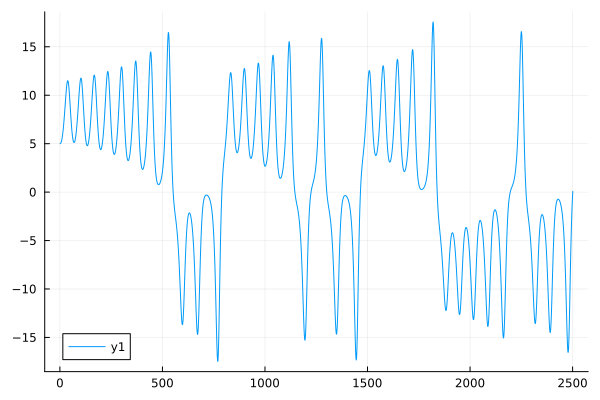

In [112]:
plot(u[:, 1])

In [113]:
un, Noise = add_noise(20, u);

# Preprocessing

### Smoothing Code

In [7]:
function SG_smoothing_optim(un, dt; order = 6, opt_alg = NelderMead(), print_window_size = false, disp_loss_landscape = false)
    """
    Performs Savitzky Golay smoothing on noisy data and returns smoothed data as well as derivative estimates.
    Everything is automatically optimized, but you can change the order if you want

    # Arguments
    * `un`: AbstractArray type holding the noisy data to be smoothed
    * `dt`: Float type holding the timestep spacing between points; defaults to 6 which should be fine
    * `order`: Int type that holds the order of polynomial fitting to be used
    * `opt_alg`: Optimization algorithm; NelderMead is okay, but ParticleSwarm is probably better
    * `disp_loss_landscape`: boolean to plot the entire loss landscape of different window values (can take a while)
    * `print_window_size`: boolean to print the exact window size that was used
    """
    ws = optim_window_size(un[:, 1], dt; order = order, opt_alg = opt_alg, disp_loss_landscape = disp_loss_landscape)
    print_window_size && print(ws)
    ues, dues = SG_smoothing_1D(un[:, 1], dt, ws, order)
    for i in 2:size(un)[2]
        ues_next, dues_next = SG_smoothing_1D(un[:, i], dt, ws, order)
        ues = hcat(ues, ues_next)
        dues = hcat(dues, dues_next)
    end
    return ues, dues
end

function optim_window_size(un, dt; order = 5, opt_alg = NelderMead(), disp_loss_landscape = false)
    function loss(w, p)
        # input validation of window size
        wn = w[1]
        if isnan(wn) || wn < order+3 || wn > size(un)[1]
            return 10000000 # returns very high loss if window size is beyond bounds
        end
        wn = iseven(round(wn)) ? Int(round(wn) - 1) : Int(round(wn))

        noise = un .- savitzky_golay(un, wn, order).y # estimated noise from savitzky golay smoothing

        # first term checks if any lags of the noise repeat, which would imply that the smoothing missed features of the actual function
        # second term checks if the noise is correlated to our initial data, which it shouldn't (smoothing the noise estimate improves performance)
        l = 10 * mean(abs.(autocor(noise))[2:end]) + abs(crosscor(un, savitzky_golay(noise, wn, order).y, [0])[1]) 

        # The 10 could be a hyperparameter, but each correlation has a maximum value of 1 so increasing it won't do much (though lowering it will)
        return l
    end

    if disp_loss_landscape
        xs = collect((order*2 + 1):2:size(un)[1])
        #xs = collect((order*2 + 1):2:100)
        ys = zeros(size(xs))
        for (i, w) in enumerate(xs)
            ys[i] = loss([w], [])
        end
        display(plot(xs, ys))
    end

    #initial guess
    w = 2.0 * order + 1

    optf = OptimizationFunction(loss, Optimization.AutoForwardDiff())
    optprob = OptimizationProblem(optf, [w]) 
    opt_w = solve(optprob, opt_alg).u[1]
    opt_w = iseven(round(opt_w)) ? Int(round(opt_w) - 1) : Int(round(opt_w))
    return opt_w
end

function SG_smoothing_1D(un, dt, window, order)
    # Performs Savitzky Golay smoothing on just one dimension of data
    # This is a helper function, you shouldn't need to call it

    ues = savitzky_golay(un, window, order).y
    dues = savitzky_golay(un, window, order, deriv=1, rate=1/dt).y
    return ues, dues
end

SG_smoothing_1D (generic function with 1 method)

In [8]:
function compare_smoothed_data(input, x, dx, xes, dxes, true_noise)
    """
    Plots multiple figures to see how estimated data compares with actual data.
    You should use this on only one dimension of the data

    # Arguments
    * `input`: noisy data
    * `x`: actual data
    * `dx`: actual derivatives
    * `xes`: estimated data
    * `dxes`: estimated derivatives
    """
    
    data = plot(input, label=false, title="Input Data")
    
    phase_space = plot(x, dx, label="true", title="Phase Space")
    plot!(xes, dxes, label="estimate")
    
    x_plot = plot(x, label="true", title="Smoothed Data")
    plot!(xes, label="estimate")
    
    dx_plot = plot(dx, label="true", title="Smoothed derivative")
    plot!(dxes, label="estimate")
    
    noise_es = input .- xes
    μ = 0.0   # mean
    σ = std(noise_es)   # standard deviation
    x_vals = LinRange(minimum(noise_es), maximum(noise_es), 100)
    y_vals = exp.(-(x_vals .- μ).^2 / (2σ^2)) / sqrt(2π*σ^2)

    noise_es_plot = plot(noise_es, label=false, title="Noise Estimate")
    noise_comparison = plot((true_noise .- noise_es), label = false, title = "Error of estimated noise")

    layout = @layout [
        a b c
        d e f
    ]
    
    plot(data, x_plot, dx_plot, phase_space, noise_es_plot, noise_comparison, layout=layout, size=(1200, 800))
end

compare_smoothed_data (generic function with 1 method)

### Datasets

In [114]:
function generateLorentzDataset(p, n, dt, T; noise = -1)
    """
    Generates a dataset of data from multiple experiments, using different initial conditions
    """

    # Define time horizon
    tspan=(0.0,T)
    u_dataset = zeros(length(0.0:dt:T), 3, n)
    du_dataset = zeros(length(0.0:dt:T), 3, n)

    for trial ∈ 1:n 
        # Define initial condition
        u0=rand(3) * 25

        # Define the ODE problem
        prob = ODEProblem(Lorenz,u0,tspan,p)
        
        # Solve the ODE problem and get the clean data 
        u=transpose(Array(solve(prob,saveat=dt)));
        
        if noise == -1
            u_dataset[:,:, trial] .= u
        else
            un, _ = add_noise(noise, u)
            u_dataset[:,:, trial] .= un
        end
        
        # Calculate the derivative
        du=zeros(size(u))
        
        # Calculate ground truth for derivative
        for i=1:size(u,1)
            du[i,:]=Lorenz(zeros(1,3), u[i,:], p, 0)
        end
        du_dataset[:, :, trial] .= du
    end
    return u_dataset, du_dataset
end


generateLorentzDataset (generic function with 1 method)

In [119]:
num_experiments = 5
dt = 0.01
un_dataset, du_dataset = generateLorentzDataset(p0, num_experiments, dt, 25; noise = 11);

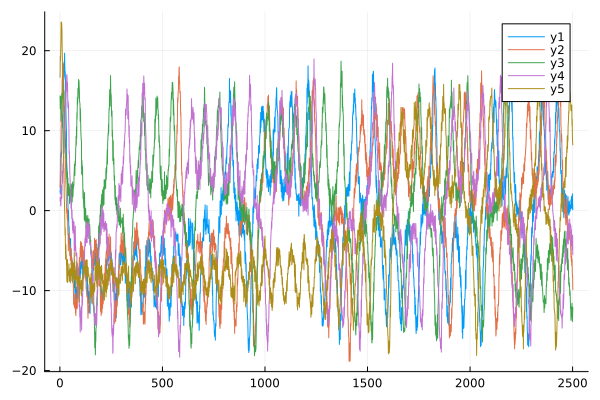

In [120]:
plot(un_dataset[:, 1, :])

In [117]:
function preprocessDataset(un_dataset, dt; opt_alg = NelderMead())
    num_experiments = size(un_dataset)[3]
    un = un_dataset[:, :, 1]
    u_data, du_data = SG_smoothing_optim(un, dt; opt_alg = opt_alg)

    for i in 2:num_experiments
        un = un_dataset[:, :, i]
        ues, dues = SG_smoothing_optim(un, dt; opt_alg = opt_alg)
        u_data = vcat(u_data, ues)
        du_data = vcat(du_data, dues)
    end
    return u_data, du_data
end

ues, dues = preprocessDataset(un_dataset, dt)
size(dues)

(25010, 3)

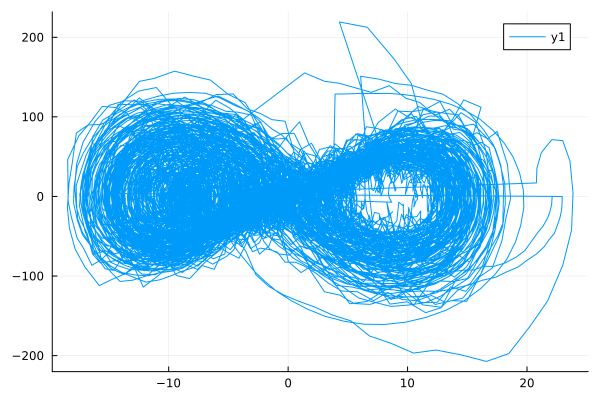

In [121]:
plot(ues[:, 1], dues[:, 1])

# Tests

First lets smooth the data

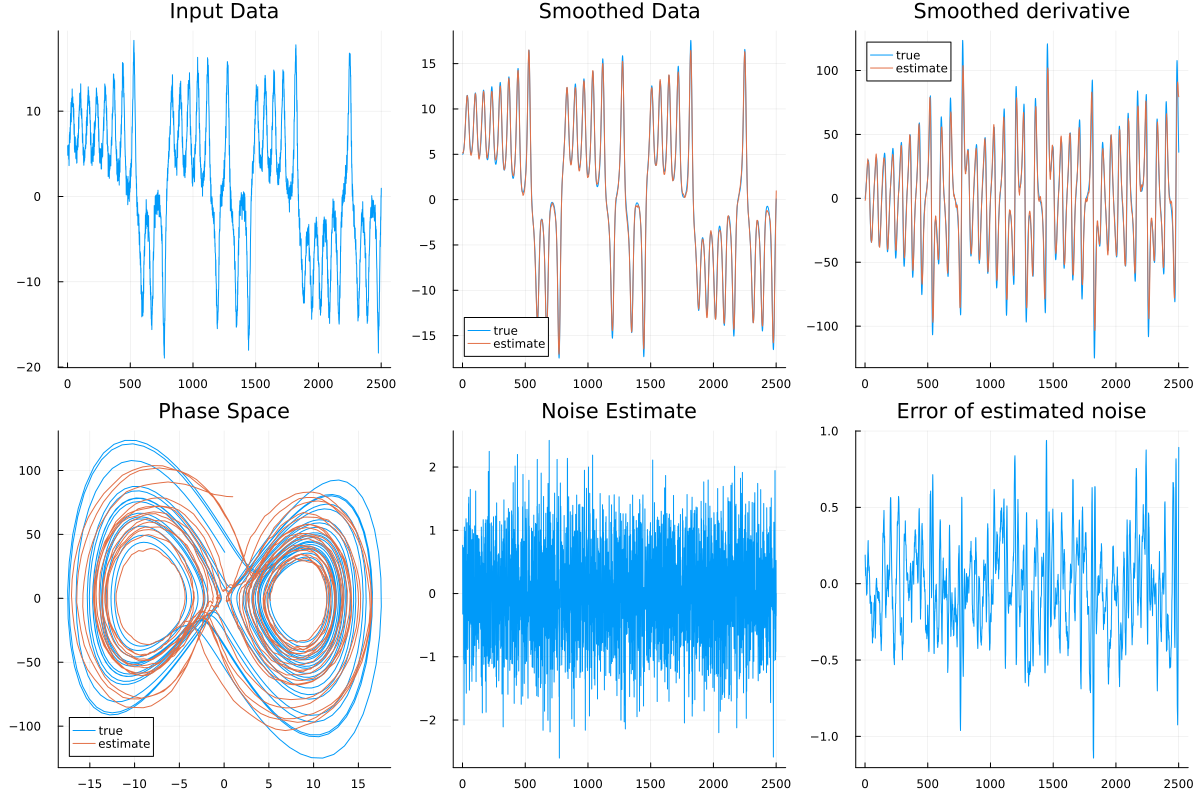

In [105]:
un, Noise = add_noise(10, u);
ues, dues = SG_smoothing_optim(un, dt; opt_alg = NelderMead())
i = 1
compare_smoothed_data(un[:, i], u[:, i], du[:, i], ues[:, i], dues[:, i], Noise[:, 1])

Now run default SINDy

In [91]:
pow_stable(a, b) = sign.(a) .* abs.(a) .^ b

function generateBasis()
    # u: The measuremt state matrix with size n x m, where n is the data length, m is the number of states. 
    # return Θ: Library matrix, with size of n x p, where p is the number of candidate terms in the library. 
    #---------------------------
    """
    u1_x1(u, x) = pow_stable.(u[:,1], x[1])
    u2_x2(u, x) = pow_stable.(u[:,2], x[2])
    u3_x3(u, x) = pow_stable.(u[:,3], x[3])
    u1u2(u, x) = pow_stable.(u[:,1], x[1]) .* pow_stable.(u[:,2], x[2])
    u1u3(u, x) = pow_stable.(u[:,1], x[1]) .* pow_stable.(u[:,3], x[3])
    u2u3(u, x) = pow_stable.(u[:,2], x[2]) .* pow_stable.(u[:,3], x[3])
    """
    
    u1(u) = pow_stable.(u[:,1], 1)
    u2(u) = pow_stable.(u[:,2], 1)
    u3(u) = pow_stable.(u[:,3], 1)
    u1u2(u) = pow_stable.(u[:,1], 1) .* pow_stable.(u[:,2], 1)
    u1u3(u) = pow_stable.(u[:,1], 1) .* pow_stable.(u[:,3], 1)
    u2u3(u) = pow_stable.(u[:,2], 1) .* pow_stable.(u[:,3], 1)

    basis = [BasisTerm(u1), 
         BasisTerm(u2),
         BasisTerm(u3),
         BasisTerm(u1u2),
         BasisTerm(u1u3),
         BasisTerm(u2u3)];
    return basis
end

generateBasis (generic function with 1 method)

In [92]:
function getErrorHeatmap(est, true_Ξ)
    err = (est .- true_Ξ) ./ true_Ξ
    tot_err = (err .* (abs.(true_Ξ) .> 0)) .+ (((abs.(est) .> 0) .- (abs.(true_Ξ) .> 0)))
    display(heatmap(tot_err, c = palette([:yellow, :black, :red], 100), clim = (-1, 1), yflip = true))
end

getErrorHeatmap (generic function with 1 method)

Testing STLSQ

In [93]:
ρ = -1

-1

25421.833439772905
expected

6×3 Matrix{Float64}:
 -10.0  28.0   0.0
  10.0  -1.0   0.0
   0.0   0.0  -2.66667
   0.0   0.0   1.0
   0.0  -1.0   0.0
   0.0   0.0   0.0

Estimate

6×3 Matrix{Float64}:
 -10.153       26.2328     0.0134381
  10.2119      -0.533709   0.0287596
   0.0          0.0       -2.62501
   0.0          0.0        0.9849
   0.00784856  -0.955123   0.0
  -0.0109777    0.0        0.0

Error

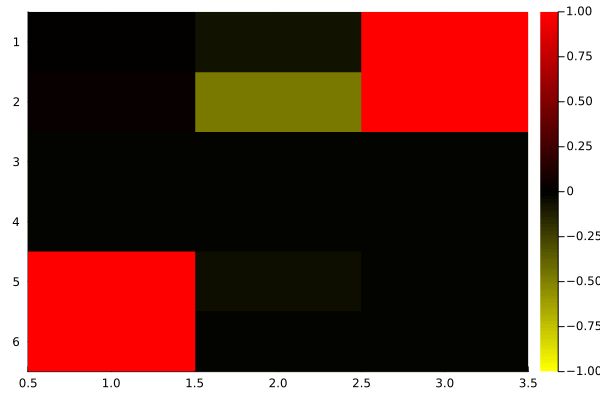

In [94]:
basis = generateBasis()

λs = exp.(-5:0.1:-0.01)
iter = 10
problem = SINDy_Problem(u, du, dt, basis, λs, iter; STRRidge = false)
true_Ξ, _ = solve_SINDy(problem)
problem = SINDy_Problem(ues, dues, dt, basis, λs, iter; STRRidge = false)
(ρ != -1) && (problem.ρ = ρ)
m, l = solve_SINDy(problem)
println(l)
print("expected")
display(true_Ξ)
print("Estimate")
display(m)
print("Error")
getErrorHeatmap(m, true_Ξ)

Estimate

6×3 Matrix{Float64}:
 -9.21888    25.1711     0.0
  9.60758    -0.25134   -0.0106256
  0.0         0.0       -2.61689
  0.0         0.0        0.979543
 -0.0128394  -0.927336   0.0
  0.0         0.0        0.0

Error

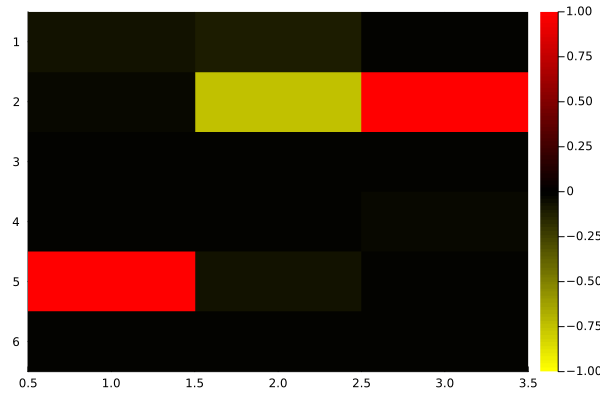

In [122]:
bagging_alg = ModifiedSINDy.BaggingSTLSQ(1000, 0.7, 0.3)

problem = SINDy_Problem(ues, dues, dt, basis, λs, iter, bagging_alg; STRRidge = false)
(ρ != -1) && (problem.ρ = ρ)
m, l = solve_SINDy(problem)
print("Estimate")
display(m)
print("Error")
getErrorHeatmap(m, true_Ξ)

Testing STRRidge

Estimate

6×3 Matrix{Float64}:
 -10.1399     26.2265    0.0134374
  10.2035     -0.53176   0.0287598
   0.0         0.0      -2.62501
   0.0         0.0       0.9849
   0.0074785  -0.95498   0.0
  -0.0107407   0.0       0.0

Error

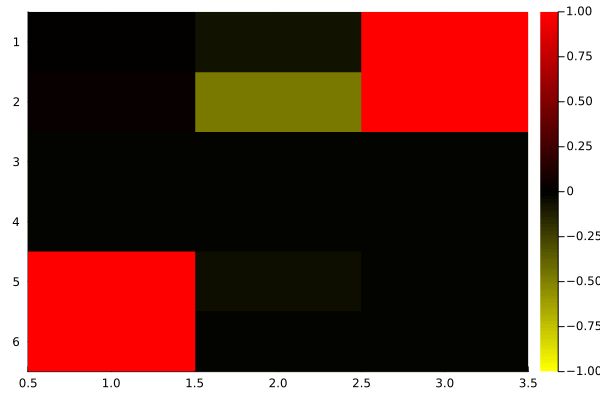

In [96]:
problem = SINDy_Problem(ues, dues, dt, basis, λs, iter; STRRidge = true)
(ρ != -1) && (problem.ρ = ρ)
m, l = solve_SINDy(problem)
print("Estimate")
display(m)
print("Error")
getErrorHeatmap(m, true_Ξ)

Estimate

6×3 Matrix{Float64}:
 -10.1109  26.079      0.0619071
  10.1845  -0.421727   0.0
   0.0      0.0       -2.62517
   0.0      0.0        0.984875
   0.0     -0.950584   0.0
   0.0      0.0        0.0

Error

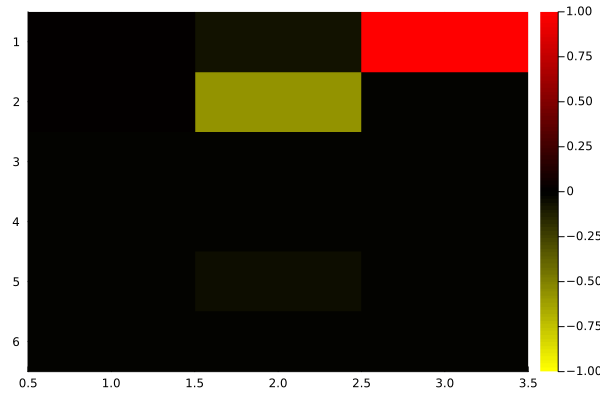

In [97]:
bagging_alg = ModifiedSINDy.BaggingSTLSQ(1000, 0.7, 0.3)

problem = SINDy_Problem(ues, dues, dt, basis, λs, iter, bagging_alg; STRRidge = true)
(ρ != -1) && (problem.ρ = ρ)
m, l = solve_SINDy(problem)
print("Estimate")
display(m)
print("Error")
getErrorHeatmap(m, true_Ξ)

# Duffing

In [106]:
function duffing(du,u,p,t)
    du[1] = u[2]
    du[2] = p[1]*u[1] - p[2]*u[1]^3 - p[3]*u[2] + p[4]*cos(p[5]*u[3])
    du[3] = 1
    return du
end

p0 = [0.2, 0.01, 2.1, 1.4, 1.2]
#p0 = [2.2, 1.1, 8.1, 2.4, 3.2]
#p0 = [10, 2, 5, 7, 1.2]
u0 = [1.0; -1.0; 0]
tspan = (0.0,50.0)

dt = 1e-1
T = tspan[1]:dt:tspan[end]

prob = ODEProblem(duffing, u0, tspan, p0)
sol = solve(prob, RK4(), adaptive = false, dt = dt)
 
u=transpose(Array(sol))
plot(u[:, 1], legend = false, xlabel = "t", ylabel = "x data")

# Calculate the derivatives
du=zeros(size(u))

# Calculate ground truth for derivative
for i=1:size(u,1)
    du[i,:]=duffing(zeros(1,3), u[i,:], p0, 0)
end

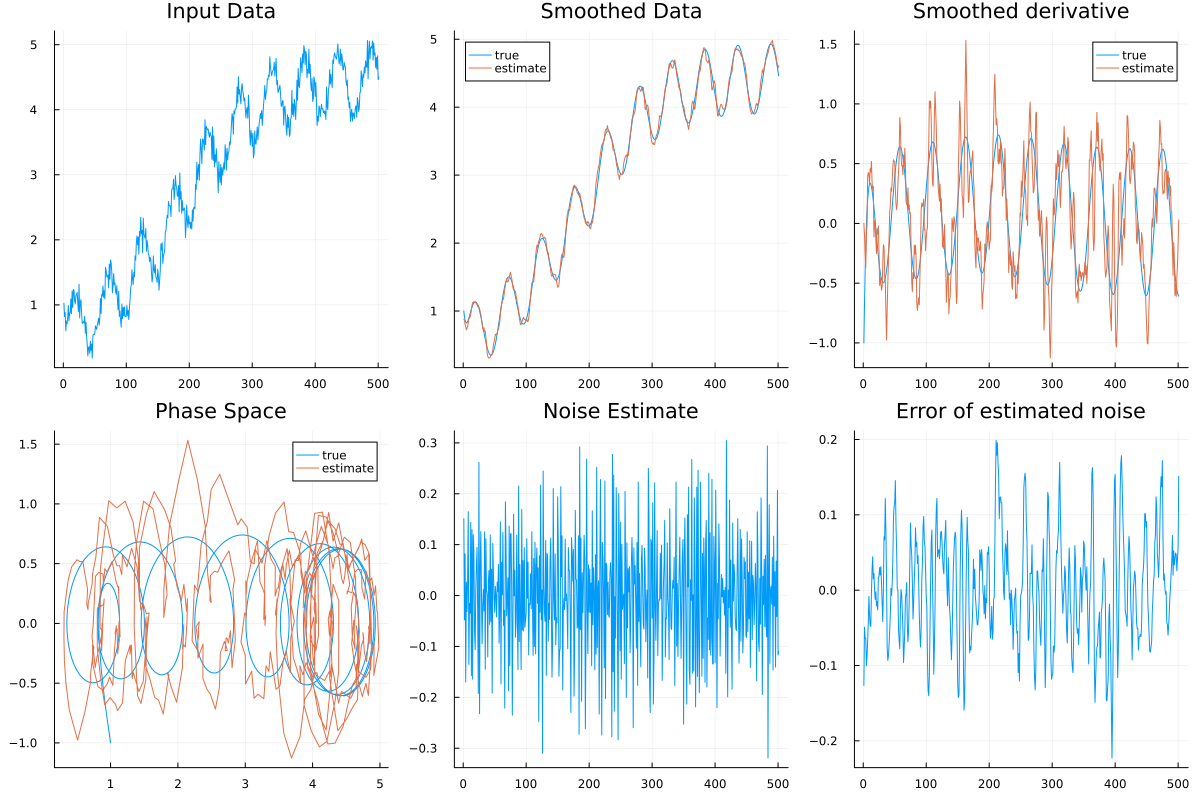

In [107]:
un, Noise = add_noise(10, u);
ues, dues = SG_smoothing_optim(un, dt; opt_alg = NelderMead())
cutoff = Int(round(0.1 * size(ues)[1]))
ues_c = ues[cutoff:end-cutoff, :]
dues_c = dues[cutoff:end-cutoff, :];
i = 1
compare_smoothed_data(un[:, i], u[:, i], du[:, i], ues[:, i], dues[:, i], Noise[:, 1])

In [26]:
dues[:, 3] .= ones(size(dues[:, 3]));

In [27]:
basis = [BasisTerm(u -> u[:, 1], 1e-3, 5e-1), 
         BasisTerm(u -> u[:, 1].^3, 1e-3, 1e-1),
         BasisTerm(u -> u[:, 2], 1e-1, 1e9),
         BasisTerm(u -> cos.(1.2.*u[:,3]), 1e-1, 1e9),
         BasisTerm(u -> u[:,3] .* 0 .+ 1, 0, 1e9)];

ρ = -1

-1

In [28]:
true_Ξ = [0 p0[1] 0; 0 -p0[2] 0; 1 -p0[3] 0; 0 p0[4] 0; 0 0 1]

5×3 Matrix{Float64}:
 0.0   0.2   0.0
 0.0  -0.01  0.0
 1.0  -2.1   0.0
 0.0   1.4   0.0
 0.0   0.0   1.0

1774.480443135361
expected

5×3 Matrix{Float64}:
 0.0   0.2   0.0
 0.0  -0.01  0.0
 1.0  -2.1   0.0
 0.0   1.4   0.0
 0.0   0.0   1.0

Estimate

5×3 Matrix{Float64}:
 0.0        0.209572    0.0
 0.0       -0.0107652   0.0
 0.988279  -1.89849     0.0258838
 0.0        1.22455    -0.0631547
 0.0       -0.048695    0.986785

Error

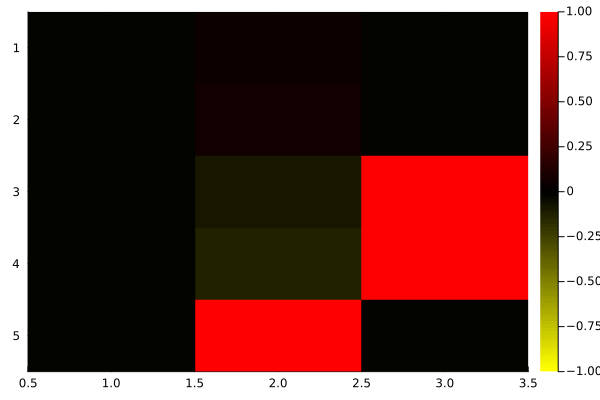

In [29]:
λs = exp.(-5:0.1:-0.01)
iter = 10
problem = SINDy_Problem(ues_c, dues_c, dt, basis, λs, iter; STRRidge = false)
(ρ != -1) && (problem.ρ = ρ)
m, l = solve_SINDy(problem)
println(l)
print("expected")
display(true_Ξ)
print("Estimate")
display(m)
print("Error")
getErrorHeatmap(m, true_Ξ)

Estimate

5×3 Matrix{Float64}:
 0.0        0.209551    0.0
 0.0       -0.0107628   0.0
 0.988294  -1.89887     0.0257941
 0.0        1.22483    -0.0630596
 0.0       -0.0486813   0.9857

Error

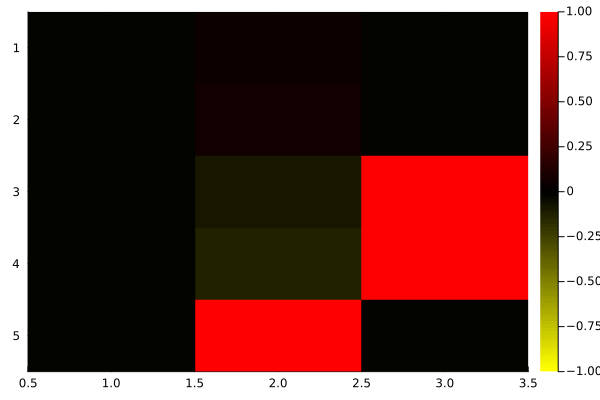

In [30]:
bagging_alg = ModifiedSINDy.BaggingSTLSQ(1000, 0.7, 0.3)

problem = SINDy_Problem(ues_c, dues_c, dt, basis, λs, iter, bagging_alg; STRRidge = false)
(ρ != -1) && (problem.ρ = ρ)
m, l = solve_SINDy(problem)
print("Estimate")
display(m)
print("Error")
getErrorHeatmap(m, true_Ξ)

STRRidge

Estimate

5×3 Matrix{Float64}:
 0.0       0.209399    0.0
 0.0      -0.0107608   0.0
 0.98779  -1.8922      0.025945
 0.0       1.22108    -0.0631718
 0.0      -0.0488695   0.986687

Error

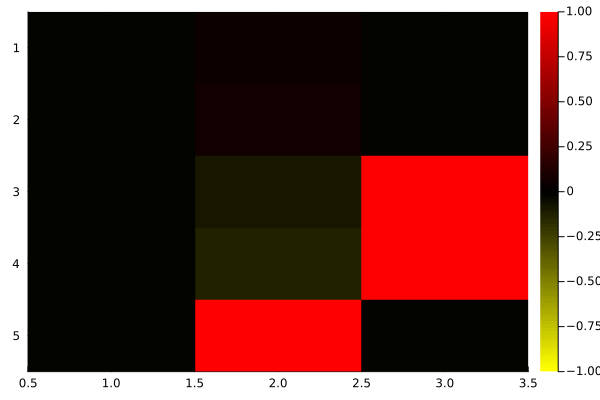

In [31]:
problem = SINDy_Problem(ues_c, dues_c, dt, basis, λs, iter; STRRidge = true)
(ρ != -1) && (problem.ρ = ρ)
m, l = solve_SINDy(problem)
print("Estimate")
display(m)
print("Error")
getErrorHeatmap(m, true_Ξ)

Estimate

5×3 Matrix{Float64}:
 0.0        0.210067    0.0
 0.0       -0.0107797   0.0
 0.988267  -1.89833     0.026607
 0.0        1.22438    -0.0635671
 0.0       -0.0496097   0.985334

Error

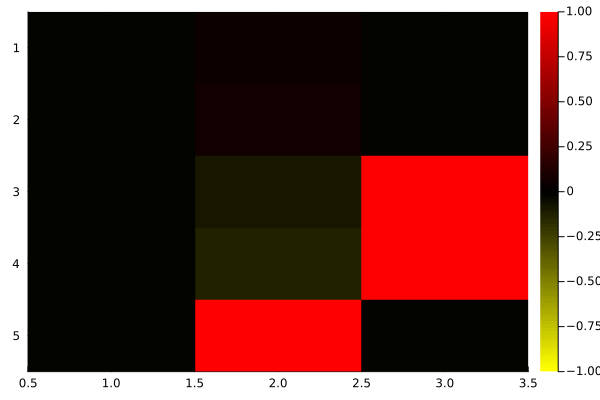

In [32]:
bagging_alg = ModifiedSINDy.BaggingSTLSQ(1000, 0.7, 0.3)

problem = SINDy_Problem(ues_c, dues_c, dt, basis, λs, iter, bagging_alg; STRRidge = true)
(ρ != -1) && (problem.ρ = ρ)
m, l = solve_SINDy(problem)
print("Estimate")
display(m)
print("Error")
getErrorHeatmap(m, true_Ξ)

## Duffing Unknown Parameter

In [73]:
unknownP(u, x) = cos.(x[1] .* u[:,3])

basis = [BasisTerm(u -> u[:, 1], 1e-3, 5e-1), 
         BasisTerm(u -> u[:, 1].^3, 1e-3, 1e-1),
         BasisTerm(u -> u[:, 2], 1e-1, 1e9),
         BandedBasisTerm(unknownP, 1e-1, 1e9, true),
         BasisTerm(u -> u[:,3] .* 0 .+ 1, 0, 1e9)];

ρ = 1

1

[1.2]
Estimate

5×3 Matrix{Float64}:
 0.0        0.0      0.0
 0.0        0.0      0.0
 0.986965  -1.65073  0.0
 0.0        1.12956  0.0
 0.0        0.0      0.987717

[1.2]
2143.6272033484574
3003
Error

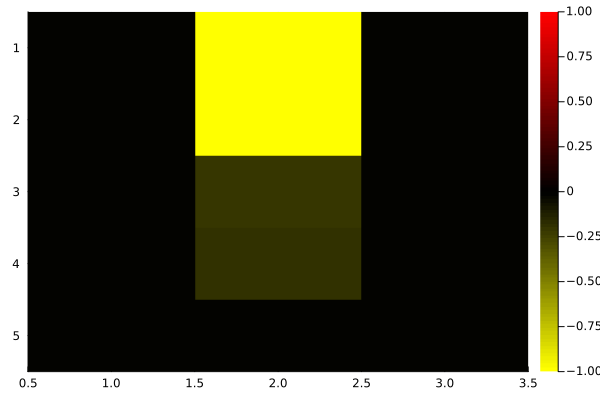

In [82]:
ADType = Optimization.AutoFiniteDiff()
opt = ParticleSwarm()
opt = NelderMead()

alg = OLE([1.2], ADType, opt)

problem = SINDy_Problem(ues_c, dues_c, dt, basis, λs, iter, alg; STRRidge = true)
(ρ != -1) && (problem.ρ = ρ)
m, l, x,n = solve_SINDy(problem)
print("Estimate")
display(m)
println(x)
println(l)
println(n)
print("Error")
getErrorHeatmap(m, true_Ξ)